<a href="https://colab.research.google.com/github/malikinza/Multivariate-Gaussian-Anomaly-Detection/blob/main/Multivariate_Gaussian_Anamoly_Detection_Credit_Card_Fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=9671fb2362b7157bf27133325794376c326b52ab2492dc6e5e68499fdb39e20f
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


In [21]:
import wget

wget.download('https://github.com/alexwolson/APS1070_data/raw/master/creditcard.tar.gz','creditcard.tar.gz')

'creditcard.tar.gz'

In [22]:
!tar -zxvf creditcard.tar.gz


creditcard.csv


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
cc = pd.read_csv('creditcard.csv')
print(cc)

fraud = cc[cc.Class == 1].shape[0] #number of fraud cases
not_fraud = cc.shape[0] - cc[cc.Class == 1].shape[0] #number of non-fraud cases

print('fraud:', fraud/cc.shape[0]*100 )
print('not fraud:', not_fraud/cc.shape[0]*100)


            Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599  0.098698  0.363787  ... -0.01830

In [ ]:
#Setting up a Gaussian object for V24

from scipy import stats

X = cc.iloc[:,1:29]
y = cc.iloc[:,30]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

loc = X_train['V24'].mean()
scale = X_train['V24'].std()
print('mean of V24:', loc)
print('standard deviation of V24:', scale)

norm = stats.norm(loc, scale) #Norm is Scipy's Gaussian distribution class


mean of V24: 0.0002942484069872571
standard deviation of V24: 0.604864187031397


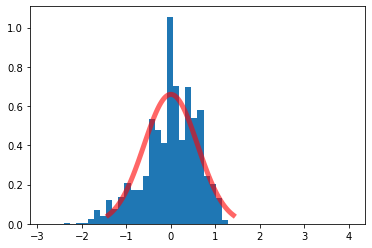

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1, 1)
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')
ax.hist(X_train['V24'].values, density=True, histtype='stepfilled', bins=50);
plt.show()

We can also look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

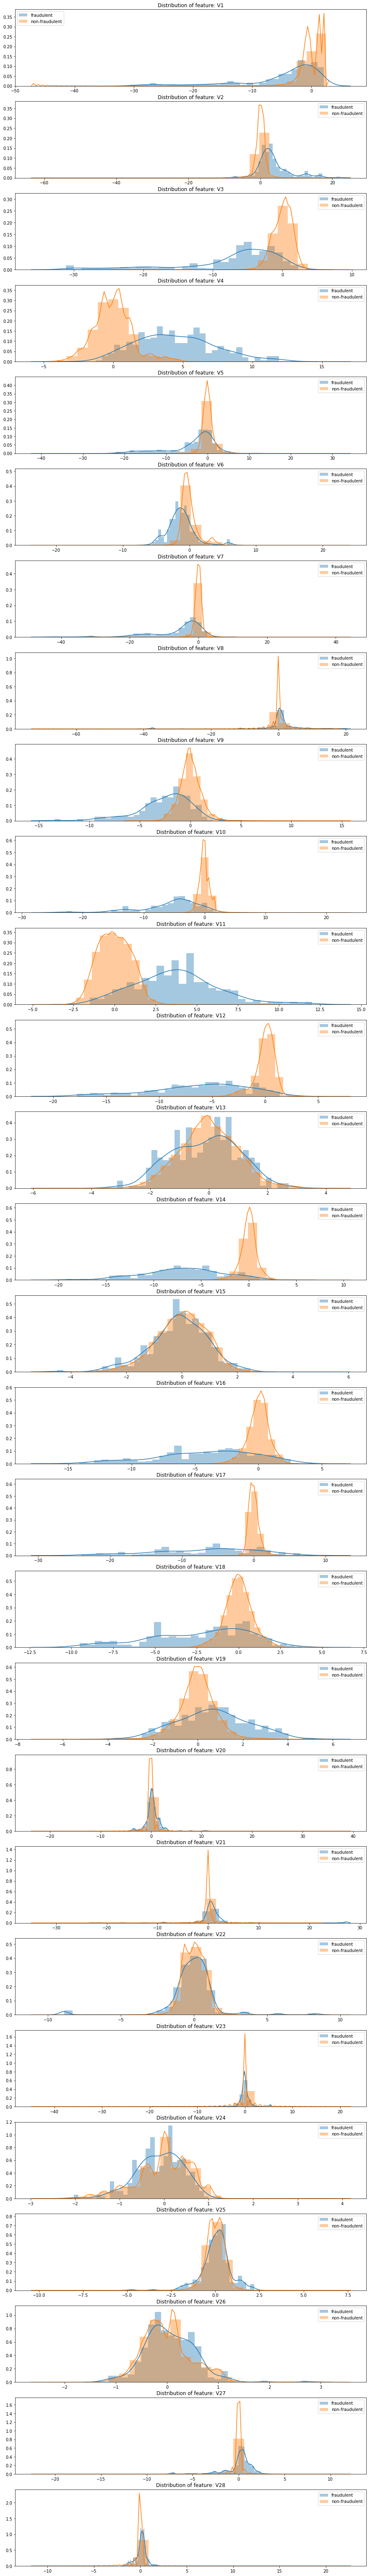

In [ ]:
#visualizing the difference in features distributions between fraudulent and non-fradulent transactions 

import matplotlib.gridspec as gridspec
import seaborn as sns
features=[f for f in cc.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(X_train[feat][y_train==1], bins=30)
    sns.distplot(X_train[feat][y_train==0],bins=30)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

In [ ]:
#MODEL 1: 5 FEATURES WITH LARGE DIFFERENCE IN DISTRIBUTION - [V4, V10, V11, V14, V17]

from sklearn.model_selection import train_test_split

#non-fraudulent data
cc_0 = cc[cc.Class==0]
X_nf = cc_0[['V4', 'V10', 'V11', 'V14','V17']]
y_nf = cc_0['Class']

#fraudulent data
cc_1 = cc[cc.Class==1]
X_f = cc_1[['V4', 'V10', 'V11', 'V14','V17']]
y_f = cc_1['Class']

#stacking the two data sets
X = np.vstack([X_nf,X_f])
y = np.hstack([y_nf,y_f])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

#plt.scatter(X[:,0],X[:,1],c=gm.score_samples(X),cmap='viridis',marker="x");


In [ ]:
#mixture of Gaussian fit on the data
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components = 5,
                    covariance_type = 'full', random_state=0)

gm.fit(X_train)

#precision and recall on the test set
import numpy as np
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#score_samples will compute the weighted log probabilities for each sample
p_gm = gm.score_samples(X_test) 

pres_score = []
rec_score = []
for i in range (1,102): 
   #sorting the points by probability
   mn_gm = sorted(p_gm)[i]
   #precision score
   precision =  precision_score(y_test,p_gm < mn_gm)
   pres_score.append(precision)
   #recall score
   recall = recall_score(y_test, p_gm < mn_gm)
   rec_score.append(recall)
   
pres_score = np.asarray(pres_score)
rec_score = np.asarray(rec_score)

print("k=1 precision score: %0.2f" %pres_score[1], 'recall score: %0.2f' %rec_score[1])
print("k=10 precision score: %0.2f" %pres_score[10], 'recall score: %0.2f' %rec_score[10])
print("k=100 precision score: %0.2f" %pres_score[100], 'recall score: %0.2f' %rec_score[100])


k=1 precision score: 1.00 recall score: 0.01
k=10 precision score: 1.00 recall score: 0.06
k=100 precision score: 0.62 recall score: 0.37


AUC of Gaussian Mixture: 0.9540629985184388


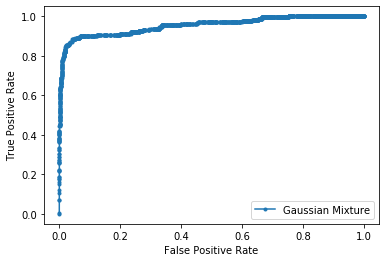

In [ ]:
#computing the ROC curve

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from matplotlib import pyplot
fpr_gm, tpr_gm, _ = roc_curve(y_test, 1-p_gm)
pyplot.plot(fpr_gm, tpr_gm, marker='.', label='Gaussian Mixture')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

#AUC Score 
auc_gm = auc(fpr_gm, tpr_gm)
print('AUC of Gaussian Mixture:', auc_gm)


In [ ]:
#MODEL 2: 5 FEATURES WITH SMALL DIFFERENCE IN DISTRIBUTION - [V2, V5, V7, V8, V21]

#non-fraudulent data set 2
cc_02 = cc[cc.Class==0]
X_nf2 = cc_0[['V2', 'V5', 'V7', 'V8','V21']]
y_nf2 = cc_0['Class']

#fraudulent data set 2
cc_12 = cc[cc.Class==1]
X_f2 = cc_1[['V2', 'V5', 'V7', 'V8','V21']]
y_f2 = cc_1['Class']

X2 = np.vstack([X_nf2,X_f2])
y2 = np.hstack([y_nf2,y_f2])
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.33, random_state=0)

#plt.scatter(X2[:,0],X2[:,1],c=gm.score_samples(X2),cmap='viridis',marker="x");

gm2 = GaussianMixture(n_components = 5,
                    covariance_type = 'full', random_state=0)

gm2.fit(X_train)

p_gm2 = gm2.score_samples(X_test) 

pres_score2 = []
rec_score2 = []
for i in range (1,102): 
   #sort the points by probability
   mn_gm2 = sorted(p_gm2)[i]
   #precision score
   precision2 =  precision_score(y_test,p_gm2 < mn_gm2)
   pres_score2.append(precision2)
   #recall score
   recall2 = recall_score(y_test, p_gm2 < mn_gm2)
   rec_score2.append(recall2)

pres_score2 = np.asarray(pres_score2)
rec_score2 = np.asarray(rec_score2)

print("k=1 precision score: %0.2f" %pres_score2[1], 'recall score: %0.2f' %rec_score2[1])
print("k=10 precision score: %0.2f" %pres_score2[10], 'recall score: %0.2f' %rec_score2[10])
print("k=100 precision score: %0.2f" %pres_score2[100], 'recall score: %0.2f' %rec_score2[100])


k=1 precision score: 0.00 recall score: 0.00
k=10 precision score: 0.18 recall score: 0.01
k=100 precision score: 0.14 recall score: 0.08


AUC of Gaussian Mixture: 0.906704089677592


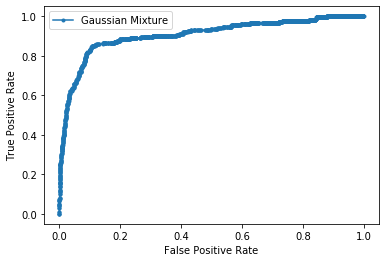

In [ ]:
#ROC curve and AUC score for the 5 new features - [V2, V5, V7, V8, V21]

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from matplotlib import pyplot
fpr_gm2, tpr_gm2, _ = roc_curve(y_test, 1-p_gm2)
pyplot.plot(fpr_gm2, tpr_gm2, marker='.', label='Gaussian Mixture')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

#Calculating AUC Scores
auc_gm2 = auc(fpr_gm2, tpr_gm2)
print('AUC of Gaussian Mixture:', auc_gm2)

In [ ]:
from astropy.table import Table, Column
t = Table()
t['K Values'] = [1, 10, 100]
t['Precision Score 1'] = [round(pres_score[1], 2), round(pres_score[10],2), round(pres_score[100],2)]
t['Precision Score 2'] = [round(pres_score2[1],2), round(pres_score2[10],2), round(pres_score2[100],2)]
t['Recall Score 1'] = [round(rec_score[1],2), round(rec_score[10],2), round(rec_score[100],2)]
t['Recall Score 2'] = [round(rec_score2[1],2), round(rec_score2[10],2), round(rec_score2[100],2)]
t

K Values,Precision Score 1,Precision Score 2,Recall Score 1,Recall Score 2
int64,float64,float64,float64,float64
1,1.0,0.0,0.01,0.0
10,1.0,0.18,0.06,0.01
100,0.62,0.14,0.37,0.08


**Comparing Model 1 and Model 2**

I chose V4, V10, V11, V14 and V17 for model 1 as these features have a large difference in distribution. For model 2, I chose features V2, V5, V7, V8 and V21 as they have a small difference in distribution. I noticed that the model performance depreciated significantly for model 2. A lower AUC score of 0.91 of model (compared to 0.95 of model 1) indicates that there was overlap between fraudelant and non-fraudelant data. Hence,the precision scores for the same k values also decreased for model 2.

As outlined in the summary table, for the same k values, model 2 (with smaller difference in distribution) reported lower precision and recall scores. The AUC score was also lower for model 2, indicating less class seperability of the data. Generally, for both models, the precision score decreased with increasing K value. Conversely, the recall score increased with increasing K. In conclusion, it is important to choose features with distint class differences to ensure optimal performance of a model. Seeing the distribution of each feature can help in creating a better detection model as some features are more correlated to the fraud/non-fraud cases.